# Behavioral Cloning for Autonomous Vehicles - Training

Ignore warnings.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Dependencies

Import libraries.

In [2]:
import os
import ntpath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

Configure TensorFlow GPU.

In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

## Read Driving Log

Import and read `Driving-Log.csv`.

In [4]:
def shorten_path(path):
    '''
    Function to view shortened paths.
    '''
    head,tail = ntpath.split(path)
    return tail

In [5]:
# Define data directory
data_directory = 'Dataset'

# Read the driving log
headers = ['Center Frame', 'Left Frame', 'Right Frame', 'Steering Angle', 'Throttle', 'Brake','Speed']
driving_log = pd.read_csv(os.path.join(data_directory,'Driving-Log.csv'), names = headers)
pd.set_option('display.max_colwidth', -1)

# Shorthen the paths
driving_log['Center Frame'] = driving_log['Center Frame'].apply(shorten_path)
driving_log['Left Frame'] = driving_log['Left Frame'].apply(shorten_path)
driving_log['Right Frame'] = driving_log['Right Frame'].apply(shorten_path)

# View the first 5 entries in the dataframe
driving_log.head()

,Center Frame,Left Frame,Right Frame,Steering Angle,Throttle,Brake,Speed
0,Center_Frame_2019_08_11_16_27_31_201.jpg,Left_Frame_2019_08_11_16_27_31_201.jpg,Right_Frame_2019_08_11_16_27_31_201.jpg,0.0,0.0,0.0,0.000241
1,Center_Frame_2019_08_11_16_27_31_272.jpg,Left_Frame_2019_08_11_16_27_31_272.jpg,Right_Frame_2019_08_11_16_27_31_272.jpg,0.0,0.0,0.0,0.000255
2,Center_Frame_2019_08_11_16_27_31_342.jpg,Left_Frame_2019_08_11_16_27_31_342.jpg,Right_Frame_2019_08_11_16_27_31_342.jpg,0.0,0.0,0.0,0.000153
3,Center_Frame_2019_08_11_16_27_31_410.jpg,Left_Frame_2019_08_11_16_27_31_410.jpg,Right_Frame_2019_08_11_16_27_31_410.jpg,0.0,0.0,0.0,0.000073
4,Center_Frame_2019_08_11_16_27_31_479.jpg,Left_Frame_2019_08_11_16_27_31_479.jpg,Right_Frame_2019_08_11_16_27_31_479.jpg,0.0,0.0,0.0,0.000069


## Load Data

Load minimal data so as to reduce memory footprint.

In [6]:
def load_data(data_directory, dataframe):
    '''
    Loads `steering_angles` from `dataframe` and `frames` as paths to center frames
    by preceeding center frame names from `dataframe` by `data_directory`.
    
    Note: `frames[i]` can be modified later to define path to left or right frames.
    '''
    frame = []
    steering_angle = []
    for i in range(len(dataframe)):
        indexed_data = dataframe.iloc[i]
        frame.append(os.path.join(data_directory, indexed_data[0].strip())) # Load only center frame paths
        steering_angle.append(float(indexed_data[3])) # Load steering angles
    frames = np.asarray(frame)
    steering_angles = np.asarray(steering_angle)
    return frames, steering_angles

In [7]:
# Load data
frames, steering_angles = load_data(data_directory+'/Camera-Frames', driving_log)

In [8]:
# Free up memory by nullifying `driving_log`
driving_log = None

## Data Balancing

Define and test data balancing here. Actual data balancing will be performed in `batch_generator`.

In [9]:
def data_balancer(frames, steering_angles, delete_rate=0.8):
    '''
    Balance the dataset by deleting a portion of `frames` and `steering_angles` where `steering_angle`
    is equal to 0. The proportion of raw data to be deleted is decided by `delete_rate`.
    '''
    # Get indices of data where steering angle is 0
    zero_steering = np.where(steering_angles == 0)[0]
    
    # Compute delete size
    delete_size = int(len(zero_steering)*delete_rate) 
    
    # Choose random indices (where steering angle is 0) to delete data from
    delete_data = np.random.choice(zero_steering, size=delete_size, replace=False)
    
    # Delete data at random indices generated earlier
    balanced_frames = np.delete(frames, delete_data, axis=0)
    balanced_steering_angles = np.delete(steering_angles, delete_data, axis=0)
    
    # Return balanced data
    return balanced_frames, balanced_steering_angles

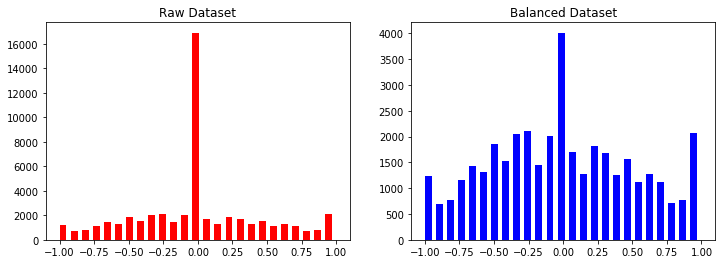

In [10]:
# Balance the dataset
balanced_frames, balanced_steering_angles = data_balancer(frames, steering_angles, delete_rate=0.8)

# Visualize the histograms of raw and balanced datasets side-by-side
figure, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(steering_angles, bins = 25, width = 0.05, color = 'red')
axes[0].set_title('Raw Dataset')
axes[1].hist(balanced_steering_angles, bins = 25, width = 0.05, color = 'blue')
axes[1].set_title('Balanced Dataset')
plt.show()

In [11]:
# Free up memory by nullifying `balanced_frames` and `balanced_steering_angles`
balanced_frames, balanced_steering_angles = None, None

## Data Augmentation

Define and test the augmentation techniques. Actual data augmentation will be performed in `batch_generator`.

### Pan

In [12]:
error_pan_x_limits = "The x_percent_min value must be <= x_percent_max value"
error_pan_y_limits = "The y_percent_min value must be <= y_percent_max value"

def pan(image, x_percent_min=-0.1, x_percent_max=0.1, y_percent_min=-0.1, y_percent_max=0.1):
    '''
    Given an `image`, pans it horizontally by a random value (in %) between `x_percent_min` and `x_percent_max`
    and vertically by a random value (in %) between `y_percent_min` and `y_percent_max`. Then, performs cropping
    such that no black borders are left, and finally resizes it to the original dimensions.
    
    Note: Resizing operation may blur the image.
    '''
    if(x_percent_min>x_percent_max):
        raise Exception(error_pan_x_limits)
    if(y_percent_min>y_percent_max):
        raise Exception(error_pan_y_limits)
    x_percent = np.random.uniform(x_percent_min,x_percent_max)
    y_percent = np.random.uniform(y_percent_min,y_percent_max)
    h, w = image.shape[:2]
    h_shift, v_shift = int(w*x_percent) , int(h*y_percent)
    trans_matrix = np.float32([[1, 0, h_shift], [0, 1, v_shift]])
    panned_image = cv2.warpAffine(image, trans_matrix, (w, h))
    if h_shift>=0:
        if v_shift>=0:
            cropped_image = panned_image[v_shift:h, h_shift:w]
        if v_shift<0:
            cropped_image = panned_image[0:h+v_shift, h_shift:w]
    if h_shift<0:
        if v_shift>=0:
            cropped_image = panned_image[v_shift:h, 0:w+h_shift]
        if v_shift<0:
            cropped_image = panned_image[0:h+v_shift, 0:w+h_shift]
    panned_image = cv2.resize(cropped_image,(w,h))
    return panned_image

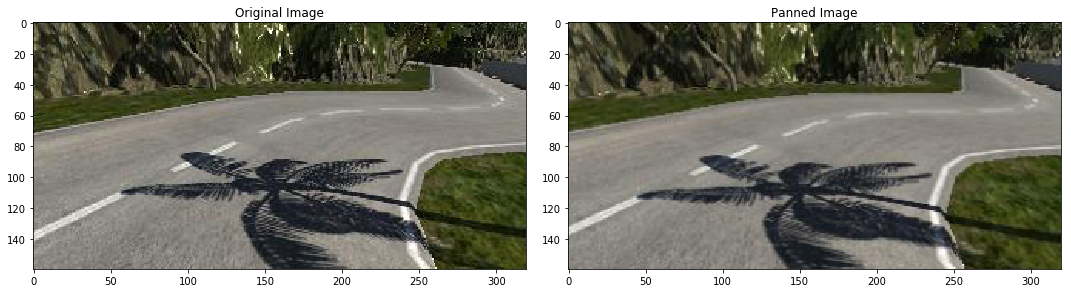

In [13]:
# Test `pan()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
panned_image = pan(original_image, -0.05, 0.05, -0.05, 0.05) # Pan by + or - 5 percent horizontally and vertically

# Visualize the original and panned images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(panned_image)
axes[1].set_title('Panned Image')
plt.show()

### Tilt

In [14]:
error_tilt_limits = "The angle_min value must be <= angle_max value"

def tilted_rectangle_with_max_area(w, h, angle):
    '''
    Given a rectangle of size (`w` x `h`) that has been rotated by `angle` (in degrees), computes
    the width and height of the largest possible axis-aligned rectangle (maximal area) within the
    rotated rectangle.
    '''
    angle = np.deg2rad(angle)
    if w <= 0 or h <= 0:
        return 0,0
    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)
    
    # Since the solutions for (angle), (-angle) and (180-angle) are all the same, it
    # suffices to look at the first quadrant and the absolute values of sin and cos.
    sin_a, cos_a = abs(np.sin(angle)), abs(np.cos(angle)) 
    
    # Half-constrained case: 
    # Two crop corners touch the longer side, the other two corners are on the mid-line parallel to the longer line.
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10: 
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    # Fully-constrained case:
    # Crop touches all 4 sides.
    else:
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a
    return wr,hr

def crop_around_center(image, w, h):
    '''
    Given an `image`, crops it to the given width `w` and height `h`, about it's centre point.
    '''
    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))
    if(w > image_size[0]):
        w = image_size[0]
    if(h > image_size[1]):
        h = image_size[1]
    x1 = int(image_center[0] - w * 0.5)
    x2 = int(image_center[0] + w * 0.5)
    y1 = int(image_center[1] - h * 0.5)
    y2 = int(image_center[1] + h * 0.5)
    return image[y1:y2, x1:x2]

def tilt(image, angle_min=-5, angle_max=5, center=None, scale=1.0):
    '''
    Given an `image`, tilts it by a random angle (in degrees) between `angle_min` and `angle_max` and
    performs cropping such that no black borders are left, then resizes it to the original dimensions.
    
    Note: Resizing operation may blur the image.
    '''
    if(angle_min>angle_max):
        raise Exception(error_tilt_limits)
    angle = np.random.uniform(angle_min,angle_max)
    (h, w) = image.shape[:2]
    if center is None:
        center = (w/2, h/2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, scale) # Compute 2D rotation matrix
    rotated_image = cv2.warpAffine(image, rot_matrix, (w, h)) # Perform the rotation
    wr,hr = tilted_rectangle_with_max_area(w, h, angle) # Compute cropping limits
    cropped_image = crop_around_center(rotated_image, wr, hr) # Crop the image to given limits about center
    tilted_image = cv2.resize(cropped_image,(w,h)) # Resize to original dimensions and append to image array
    return tilted_image

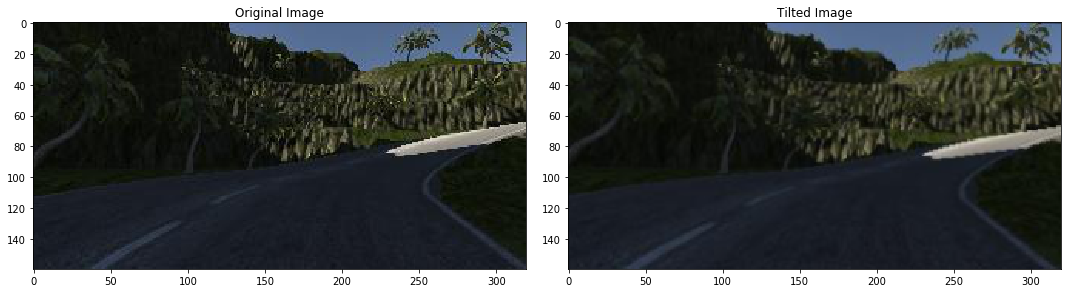

In [15]:
# Test `tilt()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
tilted_image = tilt(original_image, -1, 1) # Tilt by + or - 1 degree

# Visualize the original and tilted images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(tilted_image)
axes[1].set_title('Tilted Image')
plt.show()

### Brightness

In [16]:
error_brightness_limits = "The coeff_min value must be <= coeff_max value"

def random_brightness(image, coeff_min=-1, coeff_max=1):
    '''
    Given an `image`, alters its brightness by a random coefficenet between `coeff_min` and `coeff_max`.
    
    Note: The brightness cofficient value is defined as 0 for retaining original brightness, <0 for increasing
    darkness (i.e. reducing brightness) and >0 for increasing brightness (i.e. reducing darkness).
    '''
    if(coeff_min>coeff_max):
        raise Exception(error_brightness_limits)
    coeff = np.random.uniform(coeff_min, coeff_max)
    brightness_altered_image = cv2.convertScaleAbs(image, alpha=1, beta=100*coeff) # alpha = contrast, beta = brightness
    return brightness_altered_image

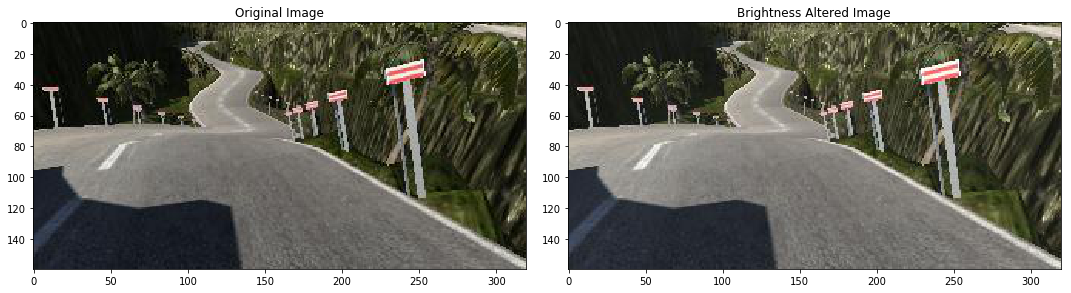

In [17]:
# Test `random_brightness()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
brightness_altered_image = random_brightness(original_image, -1, 1) # Randomly alter the brightness between -1 (dark) and 1 (bright)

# Visualize the original and brightness-altered images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(brightness_altered_image)
axes[1].set_title('Brightness Altered Image')
plt.show()

### Shadows

In [18]:
error_shadow_count = "Only 1-10 shadows can be introduced in an image"
error_invalid_rectangular_roi = "Rectangular ROI dimensions are not valid"
error_shadow_dimension = "Polygons with dimensions <3 don't exist and >10 take time to plot"

def generate_shadow_vertices(imshape, no_of_shadows, rectangular_roi, shadow_dimension):
    '''
    Helper function to generate shadow vertices based on image shape `imshape`, number of shadows `no_of_shadows`,
    region of interest coordinates `rectangular_roi` and number of sides of shadow polygons `shadow_dimension`.
    '''
    vertices_list=[]
    x1=rectangular_roi[0]
    y1=rectangular_roi[1]
    x2=rectangular_roi[2]
    y2=rectangular_roi[3]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(shadow_dimension): # Dimensionality of the shadow polygon
            vertex.append((np.random.randint(x1, x2),np.random.randint(y1, y2)))
        vertices = np.array([vertex], dtype=np.int32) # Single shadow vertices
        vertices_list.append(vertices) # List of shadow vertices
    return vertices_list

def add_shadow(image, no_of_shadows=1, shadow_darkness=0.5, rectangular_roi=(-1,-1,-1,-1), shadow_dimension=5):
    '''
    Given an `image` adds `no_of_shadows` shadows to it within the specified region of interest `rectangular_roi`.
    The `shadow_dimension` is analogous to number of sides of shadow polygon. The `shadow_darkness` parameter
    determines the darkness of the shadows (tune the `shadow_darkness` to match the darkness of the augmented 
    shadows with that of the actual shadows).
    
    Note: `rectangular_roi` is defined as (top-left x1,y1, bottom-right x2,y2).
    '''
    # Number of shadows
    if(no_of_shadows<1 or no_of_shadows>10):
        raise Exception(error_shadow_count)
    # Shadow dimensions
    if(shadow_dimension<3 or shadow_dimension>10):
        raise Exception(error_shadow_dimension)
    # ROI
    if len(rectangular_roi)==4:
        x1=rectangular_roi[0]
        y1=rectangular_roi[1]
        x2=rectangular_roi[2]
        y2=rectangular_roi[3]
    else:
        raise Exception(error_invalid_rectangular_roi)
    if rectangular_roi==(-1,-1,-1,-1):
        x1=0
        if(is_numpy_array(image)):
            y1=image.shape[0]//2
            x2=image.shape[1]
            y2=image.shape[0]
        else:
            y1=image[0].shape[0]//2
            x2=image[0].shape[1]
            y2=image[0].shape[0]
    elif x1==-1 or y1==-1 or x2==-1 or y2==-1 or x2<=x1 or y2<=y1:
        raise Exception(error_invalid_rectangular_roi)
    # Add shadows
    image_HSV = cv2.cvtColor(image,cv2.COLOR_RGB2HSV) # Conversion to HLS
    mask = np.zeros_like(image)
    imshape = image.shape
    vertices_list = generate_shadow_vertices(imshape, no_of_shadows, (x1,y1,x2,y2), shadow_dimension) # Getting list of shadow vertices
    for vertices in vertices_list:
        cv2.fillPoly(mask, vertices, 255) # Adding all shadow polygons on empty mask, single 255 denotes only red channel   
    image_HSV[:,:,2][mask[:,:,0]==255] = image_HSV[:,:,2][mask[:,:,0]==255]*shadow_darkness # If red channel is hot, image's V channel's value is lowered by a constant factor.
    shadowy_image = cv2.cvtColor(image_HSV,cv2.COLOR_HSV2RGB) # Conversion to RGB
    return shadowy_image

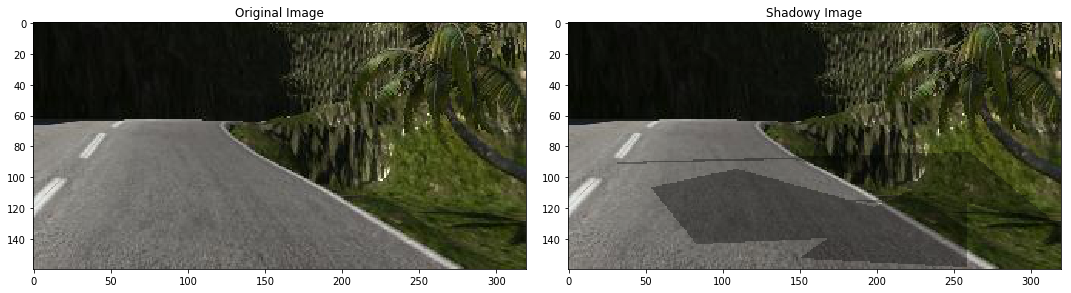

In [19]:
# Test `add_shadow()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
shadowy_image = add_shadow(original_image, 4, 0.65, (0,80,320,160), 4) # Add 4 quadrangular shadows within the specified ROI

# Visualize the original and shadowy images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(shadowy_image)
axes[1].set_title('Shadowy Image')
plt.show()

### Synthetic Cross-Track Error

In [20]:
# Global variables
x = 1.9/2 # Distance between center and left/right cameras (average vehicle width is assumed to be 1.9 m)
d = 10 # Constant recovery distance (assumed  to be 10 m)
k = x/d # Steering correction constant

def delta(theta):
    '''
    Given recorded steering angle `theta` corresponding to center viewpoint, computes
    the correction angle `delta` for left viewpoint using trigonometric relations.
    
    Note: (theta + delta) is the corrected steering angle for left viewpoint.
    '''
    return np.rad2deg(np.arctan(k/(1+np.square(np.tan(np.deg2rad(theta)))+(k*np.tan(np.deg2rad(theta))))))

def phi(theta):
    '''
    Given recorded steering angle `theta` corresponding to center viewpoint, computes
    the correction angle `phi` for right viewpoint using trigonometric relations.
    
    Note: (theta - phi) is the corrected steering angle for right viewpoint.
    '''
    return np.rad2deg(np.arctan(k/(1+np.square(np.tan(np.deg2rad(theta)))-(k*np.tan(np.deg2rad(theta))))))
    

def random_viewpoint(image_address, steering_angle):
    '''
    Probabilistically selects the viewpoint between center, left and right cameras. Adds a
    correction to the recorded steering angle if left or right camera frame is selected.
    '''    
    if np.random.rand() <= 0.5: # 50% probability
        viewpoint = np.random.choice(['Left', 'Right']) # Equal (25%) probability for selection of left or right viewpoint
    else:
        viewpoint = 'Center' # 80% probability for selection of center viewpoint
    
    if viewpoint == 'Left':
        image_address = image_address.replace('Center', 'Left')
        corrected_steering_angle = ((25*steering_angle)+delta(25*steering_angle))/25
        return viewpoint, image_address, corrected_steering_angle
    
    elif viewpoint == 'Right':
        image_address = image_address.replace('Center', 'Left')
        corrected_steering_angle = ((25*steering_angle)-phi(25*steering_angle))/25
        return viewpoint, image_address, corrected_steering_angle
    
    else:
        return viewpoint, image_address, steering_angle

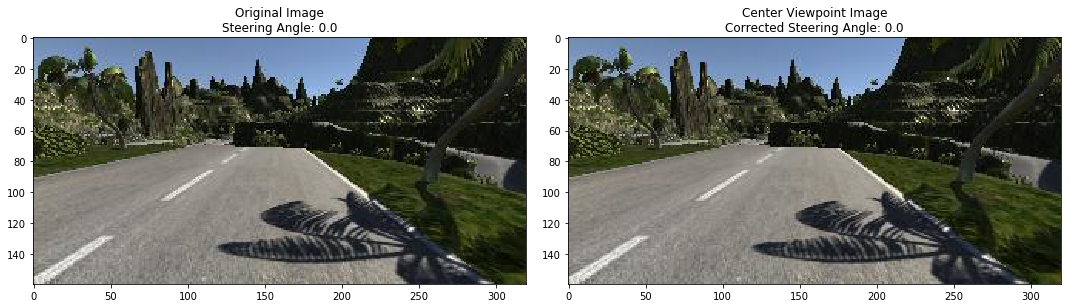

In [21]:
# Test `random_viewpoint()` on a random image
random_index = random.randint(0, len(frames)-1)
image = frames[random_index]
steering_angle = steering_angles[random_index]
original_image = mpimg.imread(image)
viewpoint, viewpoint_image, corrected_steering_angle = random_viewpoint(image, steering_angle)
viewpoint_image = mpimg.imread(viewpoint_image)

# Visualize the original and viewpoint-changed images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image\n' + 'Steering Angle: ' + str(steering_angle))
axes[1].imshow(viewpoint_image)
axes[1].set_title(viewpoint + ' Viewpoint Image\n' + 'Corrected Steering Angle: ' + str(corrected_steering_angle))
plt.show()

### Probabilistic Augmentation

In [22]:
def data_augmentor(image, steering_angle):
    '''
    Probabilistically applies the augmentation techniques defined earlier.
    
    Note: Decide the sequency of augmentation carefully (some augmentations are better applied before/after other augmentations).
    Note: Tune the probability values according to the expected variations in the environment.
    '''
    
    viewpoint, viewpoint_image, corrected_steering_angle = random_viewpoint(image, steering_angle) # Random viewpoint (with steering angle correction)
    
    viewpoint_image = mpimg.imread(viewpoint_image) # Read image taken from random viewpoint camera
    
    if np.random.rand() <= 0.3: # 30% probability
        viewpoint_image = add_shadow(viewpoint_image, 4, 0.65, (0,80,320,160), 4) # Add 4 quadrangular shadows within the specified ROI
        
    if np.random.rand() <= 0.4: # 40% probability
        viewpoint_image = random_brightness(viewpoint_image, -1, 1) # Randomly alter the brightness between -1 (dark) and 1 (bright)
    
    if np.random.rand() <= 0.1: # 10% probability
        viewpoint_image = pan(viewpoint_image, -0.05, 0.05, -0.05, 0.05) # Pan the image by + or - 5 percent horizontally and vertically 
        
    if np.random.rand() <= 0.05: # 5% probability
        viewpoint_image = tilt(viewpoint_image, -1, 1) # Tilt the image by + or - 1 degree
        
    return viewpoint_image, corrected_steering_angle

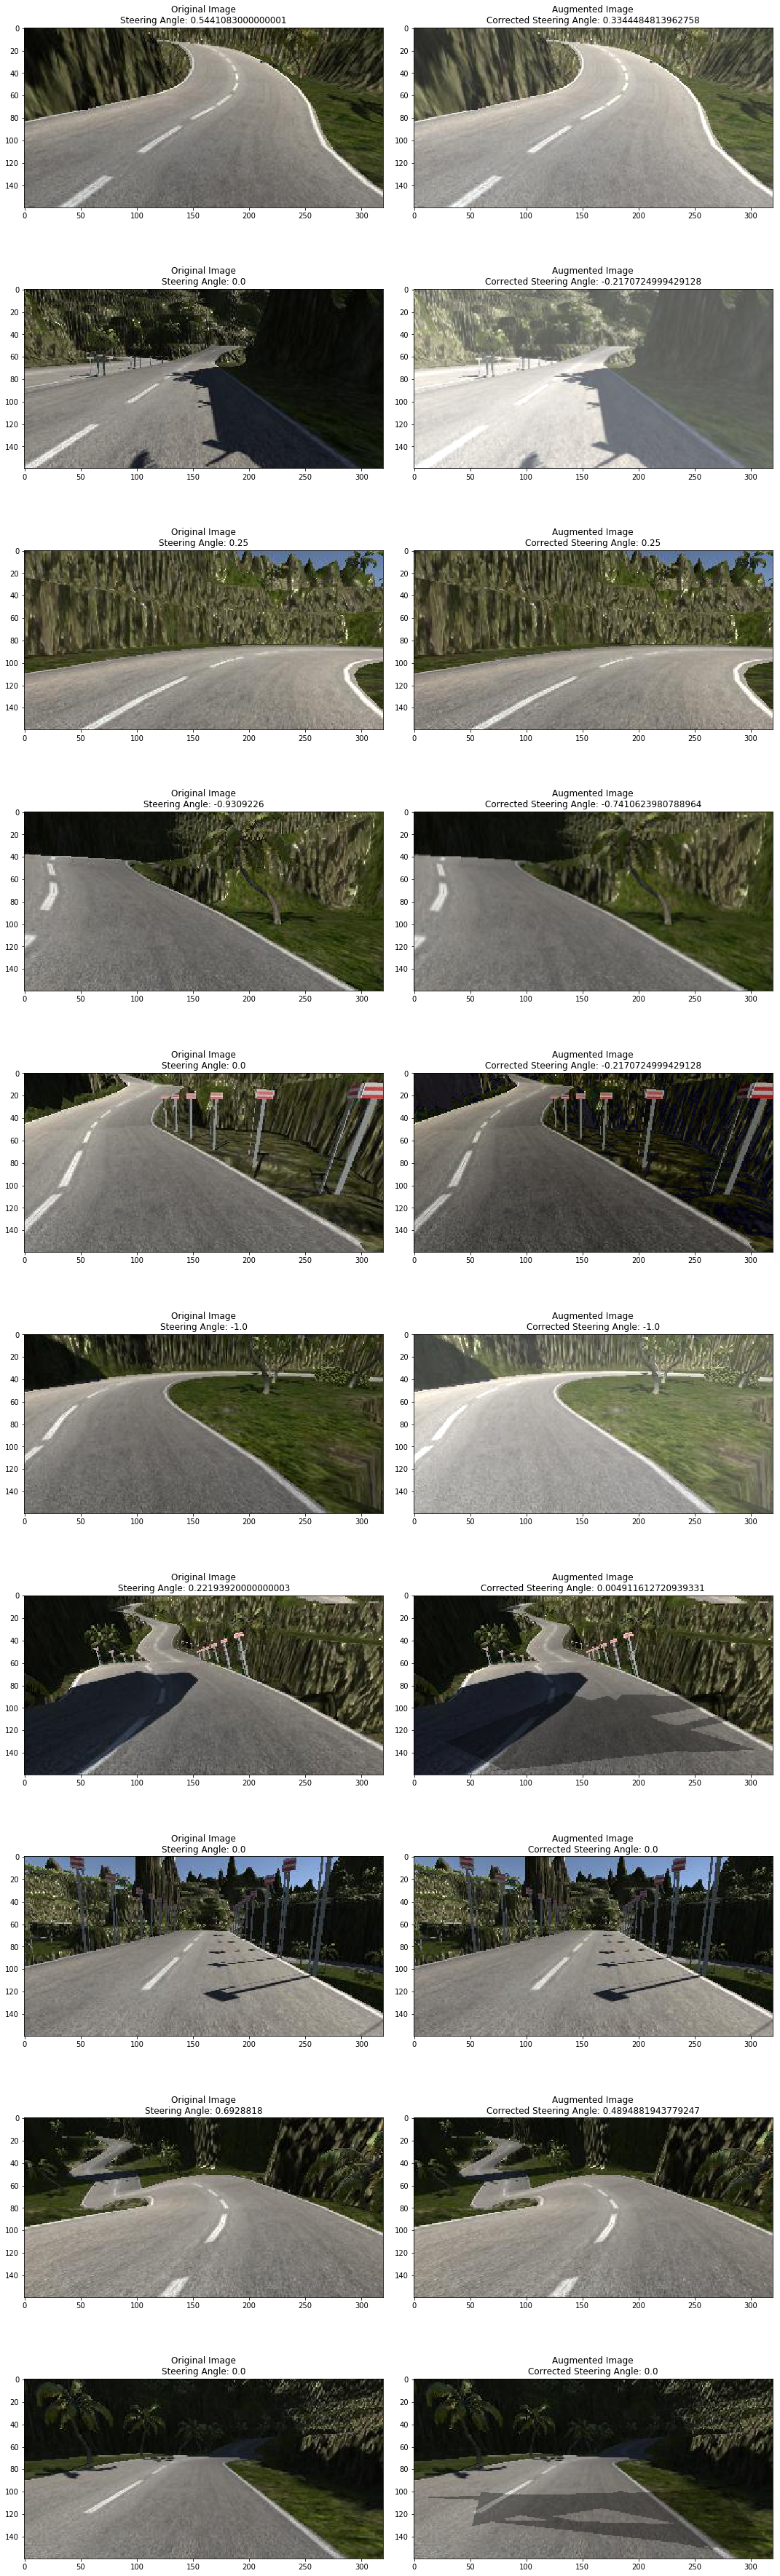

In [23]:
ncol = 2
nrow = 10

figure, axes = plt.subplots(nrow, ncol, figsize = (15, 50))
figure.tight_layout()

for i in range(10):
    # Test `data_augmentor()` on 10 random images
    random_index = random.randint(0, len(frames)-1)
    image = frames[random_index]
    steering_angle = steering_angles[random_index]
    original_image = mpimg.imread(image)
    augmented_image, corrected_steering_angle = data_augmentor(image, steering_angle)
    
    # Visualize the original and augmented images side-by-side
    axes[i][0].imshow(original_image)
    axes[i][0].set_title('Original Image\n' + 'Steering Angle: ' + str(steering_angle))
    axes[i][1].imshow(augmented_image)
    axes[i][1].set_title('Augmented Image\n' + 'Corrected Steering Angle: ' + str(corrected_steering_angle))
    
plt.show()

## Data Preprocessing

Define and test the preprocessing pipeline. Actual preprocessing will be performed in `batch_generator`.

In [24]:
def data_preprocessor(image):
    '''
    Preprocesses the input `image` by applying a series of image processing techniques.
    '''
    image = cv2.resize(image, (64, 64)) # Resize the image to the input shape used by the neural network
    image = (image/255.0)-0.5 # Normalization and mean centering
    return image

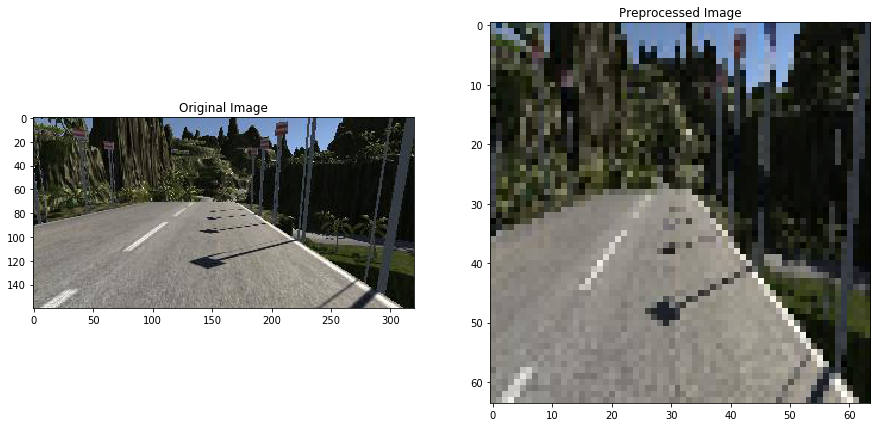

In [25]:
# Test `data_preprocessor()` on a random image
image = frames[random.randint(0, len(frames)-1)]
original_image = mpimg.imread(image)
preprocessed_image = data_preprocessor(original_image)

# Visualize the original and preprocessed images side-by-side
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image+0.5) # Add 0.5 to clip RGB image data to the valid range for imshow ([0..1] for floats or [0..255] for integers) - only for visualization
axes[1].set_title('Preprocessed Image')
plt.show()

## Data Segregation

Split the dataset into `train` and `test` sets. The `train` set will be used to train the neural network, while the `test` set will be used to validate its performance.

In [26]:
def data_segregator(frames, steering_angles, test_size=0.2):
    '''
    Splits the dataset (`frames`, `steering_angles`) into train and test sets with the specified `test_size`.
    `frames` are returned as `x_train` and `x_test` whereas corresponding `steering_angles` are returned as
    `y_train` and `y_test`.
    
    Note: `train_size` = 1 - `test_size`.
    '''
    x_train, x_test, y_train, y_test = train_test_split(frames, steering_angles, test_size = test_size, random_state = 1)
    print('Training Samples: {}\nTesting Samples: {}'.format(len(x_train), len(x_test)))
    return x_train, x_test, y_train, y_test

Training Samples: 40728
Testing Samples: 10183


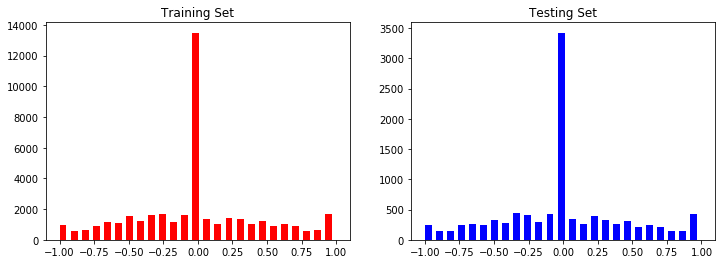

In [27]:
# Segregate the dataset into training and testing datasets
x_train, x_test, y_train, y_test = data_segregator(frames, steering_angles, test_size=0.2) # 80:20 split

# Visualize the histograms of training and testing datasets side-by-side
figure, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = 25, width = 0.05, color = 'red')
axes[0].set_title('Training Set')
axes[1].hist(y_test, bins = 25, width = 0.05, color = 'blue')
axes[1].set_title('Testing Set')
plt.show()

In [28]:
# Free up memory by nullifying `frames` and `steering_angles`
frames, steering_angles = None, None

## Batch Generator

Define a `batch_generator` to continuously yield training and testing batches. Augmentation and preprocessing is done on-the-go in order to reduce memory footprint.

In [29]:
def batch_generator(frames, steering_angles, batch_size, is_training):
    '''
    Generates batches (`batch_frames`, `batch_angles`) of size `batch_size` using the input features `frames`
    and labels `steering_angles`. The `is_training` flag allows certain operations such as dataset balancing,
    augmentation, etc. to be performed only during training, whereas other operations such as data preprocessing
    are performed during training as well as testing.
    '''
    
    # Do the following while total number of samples generated is lower than the number of 'samples_per_epoch'
    while True:

        # Do the following everytime when looping through the dataset
        if is_training:
            # Shuffle the dataset
            frames, steering_angles = shuffle(frames, steering_angles)
            # Balance the dataset
            balanced_frames, balanced_steering_angles = data_balancer(frames, steering_angles, delete_rate=0.8)
            # Define largest possible `data_size` divisible by `batch_size`
            data_size = len(balanced_frames) - len(balanced_frames)%batch_size
        else:
            # Define largest possible `data_size` divisible by `batch_size`
            data_size = len(frames) - len(frames)%batch_size
        
        # Loop through the entire dataset with an increment of `batch_size`
        for offset in range(0, data_size, batch_size):
            # Create empty lists to store batch data
            batch_frames = []
            batch_angles = []
            
            # Loop to generate a batch of (`batch_frames`, `batch_angles`)
            for i in range(batch_size):
                if is_training:
                    # Perform augmentation only when training
                    frame, angle = data_augmentor(balanced_frames[offset:offset+batch_size][i], balanced_steering_angles[offset:offset+batch_size][i])
                else:
                    # Simply read the recorded frame and corresponding steering angle during testing
                    frame = mpimg.imread(frames[offset:offset+batch_size][i])
                    angle = steering_angles[offset:offset+batch_size][i]
                
                # Preprocess the frame (during both training and testing)
                frame = data_preprocessor(frame)
                
                # Prepare a batch
                batch_frames.append(frame)
                batch_angles.append(angle)
                
            # Yield a batch
            yield (np.asarray(batch_frames), np.asarray(batch_angles))

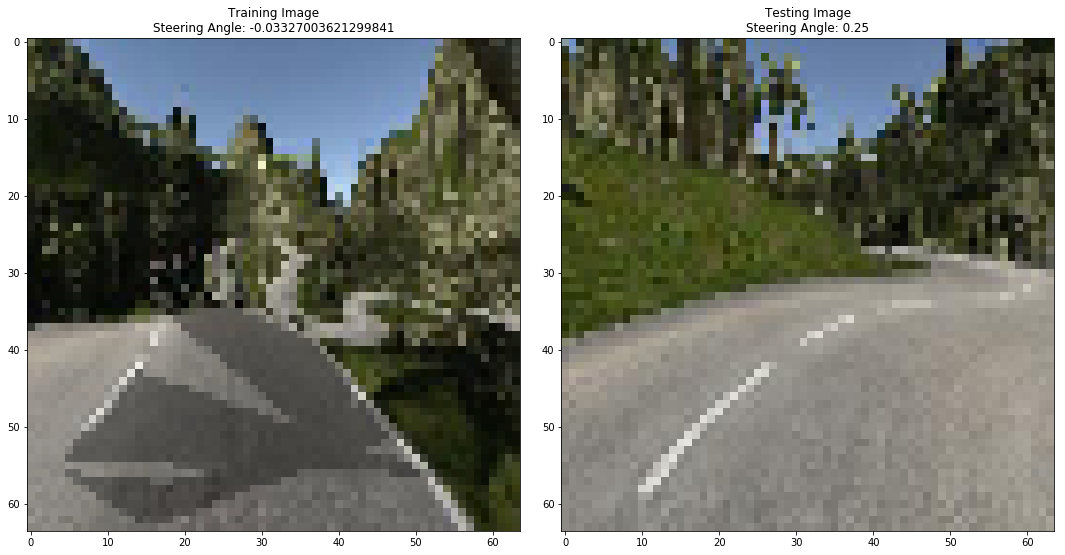

In [30]:
# Generate a train and test batch
x_train_gen, y_train_gen = next(batch_generator(x_train, y_train, 1, 1))
x_test_gen, y_test_gen = next(batch_generator(x_test, y_test, 1, 0))
figure, axes = plt.subplots(1, 2, figsize = (15, 10))
figure.tight_layout()

# Visualize the training and testing images side-by-side
axes[0].imshow(x_train_gen[0]+0.5) # Add 0.5 to clip RGB image data to the valid range for imshow ([0..1] for floats or [0..255] for integers) - only for visualization
axes[0].set_title('Training Image\n' + 'Steering Angle: ' + str(y_train_gen[0]))
axes[1].imshow(x_test_gen[0]+0.5) # Add 0.5 to clip RGB image data to the valid range for imshow ([0..1] for floats or [0..255] for integers) - only for visualization
axes[1].set_title('Testing Image\n' + 'Steering Angle: ' + str(y_test_gen[0]))
plt.show()

## Neural Network Model

Define a neural network model and compile it. Also generate a brief summary and a plot of the model.

In [31]:
def model():
    model = Sequential()
    model.add(Convolution2D(8, (11, 11), strides = (5, 5), input_shape = (64, 64, 3), activation = 'relu', name = 'CONV1'))
    model.add(Convolution2D(16, (5, 5), strides = (2, 2), activation = 'relu', name = 'CONV2'))
    model.add(Convolution2D(32, (3, 3), strides = (2, 2), activation = 'relu', name = 'CONV3'))
    model.add(Flatten(name = 'Flatten'))
    model.add(Dense(64, activation = 'relu', name = 'FC1'))
    model.add(Dropout(0.25, name = 'DROP1'))
    model.add(Dense(16, activation = 'relu', name = 'FC2'))
    model.add(Dropout(0.25, name = 'DROP2'))
    model.add(Dense(8, activation = 'relu', name = 'FC3'))
    model.add(Dropout(0.25, name = 'DROP3'))
    model.add(Dense(1, name = 'OUTPUT'))
    model.compile(loss = 'mse', optimizer = Adam(lr = 1e-3))
    return model

In [32]:
model = model() # Select model
print(model.summary()) # Model summary

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 11, 11, 8)         2912      
_________________________________________________________________
CONV2 (Conv2D)               (None, 4, 4, 16)          3216      
_________________________________________________________________
CONV3 (Conv2D)               (None, 1, 1, 32)          4640      
_________________________________________________________________
Flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
FC1 (Dense)                  (None, 64)                2112      
_________________________________________________________________
DROP1 (Dropout)              (None, 64)                0         
____

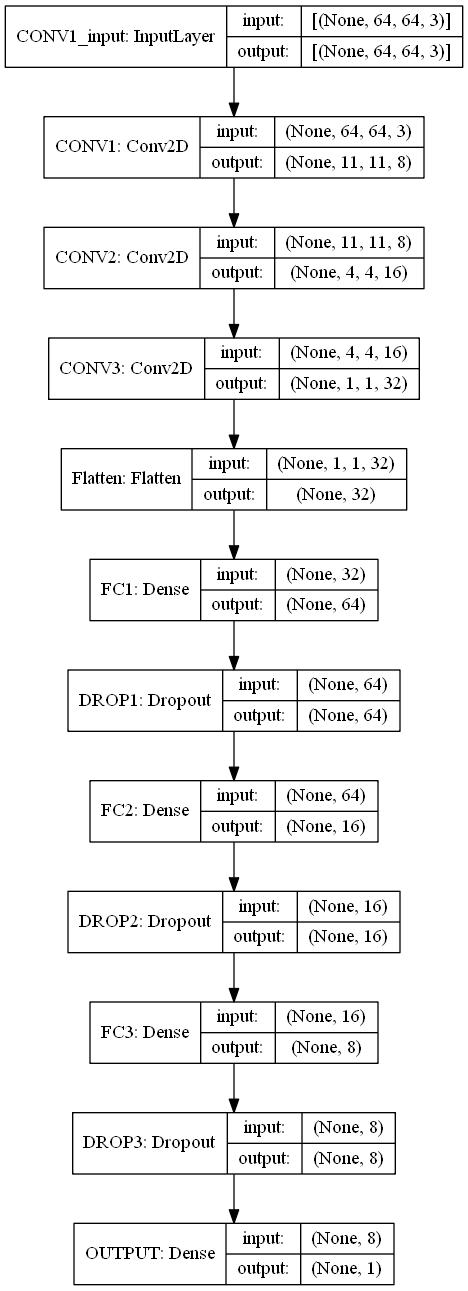

In [33]:
# Plot the model
plot_model(model, to_file='Neural Network Architecture.png', show_shapes=True, show_layer_names=True)

## Training

Train the neural network and analyze its performance. Finally, save the model as `Rigorous_Driving_Behaviour_Model.h5`.

### Train the Model

In [34]:
# Training hyperparameters
epochs = 10 # Number of epochs
batch_size = 256 # Batch size
augmentation_loops = 64 # Number of times to loop through the dataset, performing random augmentations each time
train_steps = np.ceil(len(x_train)/batch_size) * augmentation_loops # Steps per epoch during training
test_steps = np.ceil(len(x_test)/batch_size) # Steps per epoch during testing

In [35]:
history = model.fit_generator(
                                batch_generator(x_train, y_train, batch_size = batch_size, is_training = 1),
                                steps_per_epoch = train_steps, 
                                epochs = epochs,
                                validation_data = batch_generator(x_test, y_test, batch_size = batch_size, is_training =  0),
                                validation_steps = test_steps,
                                verbose = 1,
                                shuffle = 1
                             )

Epoch 1/10
10240/10240 [==============================] - 3907s 382ms/step - loss: 0.1097 - val_loss: 0.0633
Epoch 2/10
10240/10240 [==============================] - 3871s 378ms/step - loss: 0.0996 - val_loss: 0.0640
Epoch 3/10
10240/10240 [==============================] - 3976s 388ms/step - loss: 0.0973 - val_loss: 0.0630
Epoch 4/10
10240/10240 [==============================] - 4005s 391ms/step - loss: 0.0960 - val_loss: 0.0629
Epoch 5/10
10240/10240 [==============================] - 3889s 380ms/step - loss: 0.0950 - val_loss: 0.0631
Epoch 6/10
10240/10240 [==============================] - 3971s 388ms/step - loss: 0.0944 - val_loss: 0.0631
Epoch 7/10
10240/10240 [==============================] - 3977s 388ms/step - loss: 0.0939 - val_loss: 0.0643
Epoch 8/10
10240/10240 [==============================] - 3993s 390ms/step - loss: 0.0935 - val_loss: 0.0648
Epoch 9/10
10240/10240 [==============================] - 3948s 386ms/step - loss: 0.0929 - val_loss: 0.0643
Epoch 10/10
10240/1

### Evaluation

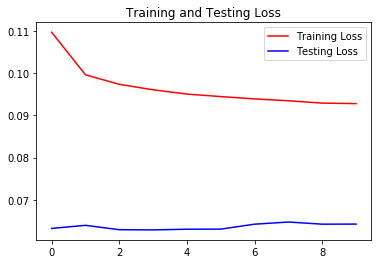

In [36]:
# Get training and testing losses for all the epochs from `history`
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

# Plot the training and testing loses
plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Testing Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

### Save the Trained Model

In [37]:
model.save('Rigorous_Driving_Behaviour_Model.h5')